In [30]:
from scipy.integrate import odeint
from scipy.optimize import minimize

import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
plot.style.use('seaborn')

experiment = 'calibracion_resistencia_20231109_1'

# Load Data
data = pd.read_csv(experiment + '/data.csv')
data.loc[:, "Time"] = data.loc[:, "Time"] * 3600
data = data.reset_index().drop(columns=['index'])

In [15]:
def electric_heater(T, t, parameters, u):
    # Parameters
    # U_loss = heat losses to air
    # A = area of heat Transfer
    # T_amb = ambient temperature
    # gain = gain

    UA_loss = parameters[0]  # W / m^2 s
    gain = parameters[1]  #
    mcpr = parameters[2]
    A = 0.05346  # m^2
    T_amb = 24.93  # Celsius
    R_mass = 212.4  # grams
    Cpr = 0.710  # J / g K

    Q_loss = UA_loss * (T - T_amb)
    dTrdt = (gain * u - Q_loss) / mcpr

    return dTrdt


def simulate(parameters):
    initial_conditions = data.loc[0, "T_heater"]
    simulation_results = pd.DataFrame(columns=["Time", "u", "T_heater"])
    simulation_results.loc[0, "Time"] = data.loc[0, "Time"]
    simulation_results.loc[0, "T_heater"] = initial_conditions
    simulation_results.loc[0, "u"] = data.loc[0, "PWM"]

    N = len(data)
    time = data.loc[0:, "Time"]
    u = data.loc[0:, "PWM"]

    for i in range(1, N):
        time_interval = [time[i - 1], time[i]]
        solution = odeint(
            electric_heater, initial_conditions, time_interval, args=(parameters, u[i - 1])
        )

        simulation_results.loc[i, "Time"] = time[i]
        simulation_results.loc[i, "T_heater"] = solution[-1][0]
        simulation_results.loc[i, "u"] = u[i]
        initial_conditions = solution[-1][0]

    return simulation_results


def squared_error(simulation_results):
    y = data.loc[:, "T_heater"].to_numpy()
    yhat = simulation_results.loc[:, "T_heater"].to_numpy()

    return np.dot((y - yhat).transpose(), (y - yhat))

def objective(parameters):
    simulation_results = simulate(parameters)
    objective = squared_error(simulation_results)

    return objective / len(data)

In [40]:
parameters_df = pd.DataFrame(columns=["U_loss", "Gain", "mcpr"])
parameters_df.loc[0, "U_loss"] = 0.6484375   # Heat losses to air
parameters_df.loc[0, "Gain"] = 0.12654687  # Heat gain from electric current
parameters_df.loc[0, "mcpr"] = 150.8
new_results = simulate(parameters_df.iloc[0, :].to_list())
iter = 0

In [41]:
%%time
iter = iter + 1

# Simulate model with parameters
old_parameters = parameters_df.loc[iter - 1, :].to_list()
old_results = new_results
new_parameters = minimize(
    objective, old_parameters, bounds=[(0, None), (0, None), (0, None)],
    method='Nelder-Mead', tol=0.1
)
parameters_df.loc[iter, :] = new_parameters.x
new_results = simulate(parameters_df.iloc[-1, :].to_list())

CPU times: user 5min 58s, sys: 702 ms, total: 5min 59s
Wall time: 6min


In [42]:
new_parameters

 final_simplex: (array([[7.00943534e-01, 1.31919013e-01, 1.53002365e+02],
       [7.00938142e-01, 1.31919101e-01, 1.53061088e+02],
       [7.00941058e-01, 1.31917199e-01, 1.53025806e+02],
       [7.00896121e-01, 1.31912270e-01, 1.52928267e+02]]), array([1.42774508, 1.42774509, 1.42774513, 1.42774516]))
           fun: 1.4277450831455993
       message: 'Optimization terminated successfully.'
          nfev: 82
           nit: 44
        status: 0
       success: True
             x: array([7.00943534e-01, 1.31919013e-01, 1.53002365e+02])

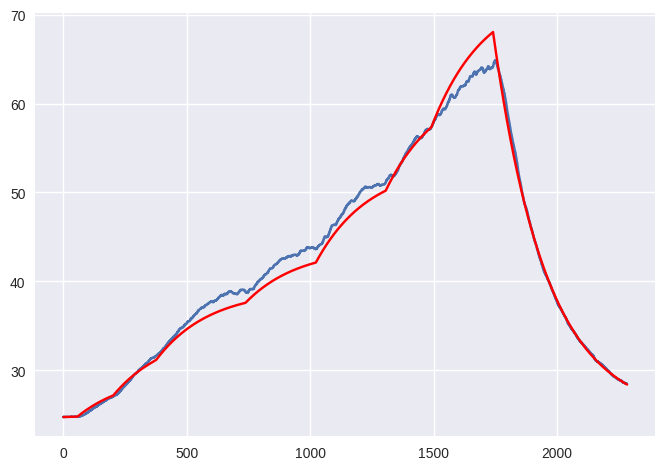

In [43]:
plot.plot(data.loc[:, "Time"], data.loc[:, "T_heater"], new_results.loc[:, "Time"], new_results.loc[:, "T_heater"], 'r')
plot.show()

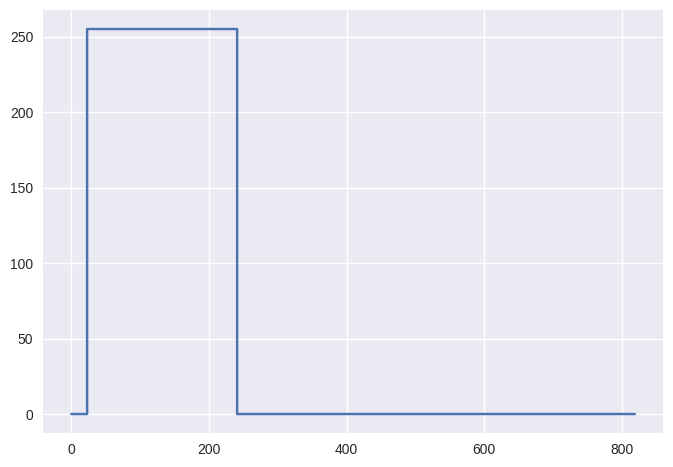

In [9]:
plot.plot(data.loc[:, "Time"], data.loc[:, "PWM"])
plot.show()

In [7]:
y = data.loc[:, "T_heater"].to_numpy()
yhat = simulation_results.loc[:, "T_heater"].to_numpy()

np.dot((y - yhat).transpose(), (y - yhat))

673047.4567106691

In [6]:
simulation_results = simulate([12.72345699, 0.12901237])